#Setup

##Import the needed packages

In [2]:
import os
import cv2
from transformers import ViTFeatureExtractor, TFViTForImageClassification, create_optimizer
import pandas as pd
import numpy as np
from tensorflow import keras
import tensorflow as tf
from keras import layers
from keras_preprocessing.image import ImageDataGenerator
from keras import utils
from keras.regularizers import L2
from keras import backend as K
import datetime
from PIL import Image
import matplotlib.pyplot as plt

##Define the constants

In [3]:
MODEL_ID = 'google/vit-base-patch16-224-in21k'
EPOCHS = 4
TRAIN_BATCH_SIZE = 18
VALID_BATCH_SIZE = 18
LEARNING_RATE = 0.000001
WEIGHT_DECAY_RATE = 0.01
LOAD_PREVIOUS_MODEL = True
PATH_MODEL_1 = "test/test_config_train.json"
PATH_MODEL_2 = "test/test_config_infer.json"
PATH_WEIGHTS_1 = "test/test_weights_train.h5"
PATH_WEIGHTS_2 = "test/test_weights_infer.h5"

##Create the generator with all the augmentations

In [4]:
train_datagen=ImageDataGenerator(rescale=1./255., 
                            rotation_range=10, 
                            fill_mode='nearest',
                            width_shift_range=0.1, 
                            height_shift_range=0.1,
                            horizontal_flip=True, 
                            data_format= "channels_first",
                            validation_split=0.1,
                            #preprocessing_function = our_preprocessing_function
                            )

##Flow data from directory to generator

In [5]:
train_generator = train_datagen.flow_from_directory(
    directory="KaggleDataset",
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=TRAIN_BATCH_SIZE,
    class_mode='binary',
    shuffle=True,
    seed=42
)

valid_generator = train_datagen.flow_from_directory(
    directory="KaggleDataset",
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=TRAIN_BATCH_SIZE,
    class_mode='binary',
    shuffle=True,
    seed=42,
    subset='validation'
)

Found 4200 images belonging to 2 classes.
Found 420 images belonging to 2 classes.


##Define the evaluation metrics

In [6]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

#Training the model

##Define the model

In [7]:
def create_model():
    #Load the pretrained model from huggingface
    base_model = TFViTForImageClassification.from_pretrained(MODEL_ID, output_attentions=True)

    #Define the input layer
    input = keras.layers.Input(shape=(3,224,224), name='pixel_values', dtype='float32')

    #Define transformer layers and add them to the model
    vit, attention_scores= base_model.vit(input)[0], base_model.vit(input)[1]

    #Define the output layer and add it to the model
    classifier = keras.layers.Dense(1, kernel_regularizer=L2(0.03), bias_regularizer=L2(0.03), activation='sigmoid', name='outputs')(vit[:, 0, :])

    #Create two models, one for traning, and other for inference
    model1 = keras.Model(inputs=input, outputs=[classifier], name='VitTrainner')
    model2 = keras.Model(inputs=input, outputs=[classifier, attention_scores], name='Vit')
    
    return model1, model2

##Create a new model of load a previous one

In [8]:
if LOAD_PREVIOUS_MODEL:
    with open(PATH_MODEL_1) as json_file:
        json_config = json_file.read()
    transformerTrainner = keras.models.model_from_json(json_config)
    transformerTrainner.load_weights(PATH_WEIGHTS_1)

    with open(PATH_MODEL_2) as json_file:
        json_config = json_file.read()
    transformer = keras.models.model_from_json(json_config)
    transformer.load_weights(PATH_WEIGHTS_2)
else:
    transformerTrainner, transformer = create_model()

##Compile the model

In [9]:
num_train_steps = 6328 * EPOCHS
optimizer, lr_schedule = create_optimizer(
    init_lr=LEARNING_RATE,
    num_train_steps=num_train_steps,
    weight_decay_rate=WEIGHT_DECAY_RATE,
    num_warmup_steps=0,
)

#Compile the model but only the classifier layer

transformerTrainner.compile(optimizer=optimizer,
        loss=[keras.losses.BinaryCrossentropy(), None],
        metrics=[[keras.metrics.BinaryAccuracy(), f1_m, precision_m, recall_m], None],
        loss_weights=[1.0, 0.0]
)
        

transformer.compile(optimizer=optimizer,
        loss=keras.losses.BinaryCrossentropy(),
        metrics=[keras.metrics.BinaryAccuracy(), f1_m, precision_m, recall_m]
)

In [10]:
PATH_TEST = "NOR2.jpg"

image = Image.open(PATH_TEST).convert("RGB")
image = image.resize((224, 224))

#Scale the image
image = np.array(image) / 255.0

# Prepare the image for the model.
img = np.array(image)
#Move the color channel to the first dimension
img = np.moveaxis(img, -1, 0)
    
img = np.expand_dims(img, axis=0)

print(transformerTrainner.predict(img))


[[0.01654989]]


##Fit the model

In [14]:
history = transformerTrainner.fit(train_generator,
                #steps_per_epoch = train_generator.samples // TRAIN_BATCH_SIZE,
                validation_data = valid_generator, 
                #validation_steps = valid_generator.samples // VALID_BATCH_SIZE,
                epochs=EPOCHS,
                #callbacks=[tensorboard_callback]
)

Epoch 1/4
234/234 [==============================] - 161s 686ms/step - loss: 0.0572 - binary_accuracy: 1.0000 - f1_m: 0.9530 - precision_m: 0.9530 - recall_m: 0.9530 - val_loss: 0.0639 - val_binary_accuracy: 0.9952 - val_f1_m: 0.9857 - val_precision_m: 1.0000 - val_recall_m: 0.9757
Epoch 2/4
234/234 [==============================] - 160s 683ms/step - loss: 0.0563 - binary_accuracy: 1.0000 - f1_m: 0.9530 - precision_m: 0.9530 - recall_m: 0.9530 - val_loss: 0.0563 - val_binary_accuracy: 1.0000 - val_f1_m: 1.0000 - val_precision_m: 1.0000 - val_recall_m: 1.0000
Epoch 3/4
234/234 [==============================] - 160s 683ms/step - loss: 0.0615 - binary_accuracy: 0.9981 - f1_m: 0.9560 - precision_m: 0.9557 - recall_m: 0.9583 - val_loss: 0.0552 - val_binary_accuracy: 1.0000 - val_f1_m: 1.0000 - val_precision_m: 1.0000 - val_recall_m: 1.0000
Epoch 4/4
234/234 [==============================] - 160s 683ms/step - loss: 0.0572 - binary_accuracy: 0.9993 - f1_m: 0.9635 - precision_m: 0.9658 - re

##Save the model

In [15]:
json_config = transformer.to_json()
with open(PATH_MODEL_2, 'w') as json_file:
    json_file.write(json_config)
# Guardar pesos en el disco
transformer.save_weights(PATH_WEIGHTS_2)

json_config = transformerTrainner .to_json()
with open(PATH_MODEL_1, 'w') as json_file:
    json_file.write(json_config)
# Guardar pesos en el disco
transformer.save_weights(PATH_WEIGHTS_1)

In [48]:
valid_generator.labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

#Evaluate and analize the model

##Define the heatmap

In [15]:
def attention_heatmap(attention_score_tuple, image, model_type="dino"):
    num_tokens = 2 if "distilled" in model_type else 1


    # Process the attention maps for overlay.
    w_featmap = image.shape[2] // 16
    h_featmap = image.shape[1] // 16
    attention_scores = attention_score_tuple[0]

    # Taking the representations from CLS token.
    attentions = attention_scores[0, :, 0, num_tokens:].reshape(12, -1)

    # Reshape the attention scores to resemble mini patches.
    attentions = attentions.reshape(12, w_featmap, h_featmap)
    attentions = attentions.transpose((1, 2, 0))

    # Resize the attention patches to 224x224 (224: 14x16).
    attentions = tf.image.resize(
        attentions, size=(h_featmap * 16, w_featmap * 16)
    )
    return attentions

In [30]:
PATH_TEST = "Cavidad RX.jpg"

(224, 224)


TypeError: Invalid shape (224, 224, 12) for image data

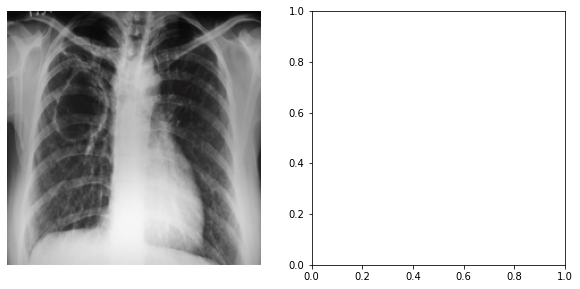

In [33]:
##Get the heatmap for test image
image = Image.open(PATH_TEST).convert("RGB")
image = image.resize((224, 224))

#Scale the image
img = np.array(image) 

img = img / 255.0
# Prepare the image for the model.

#Move the color channel to the first dimension
img = np.moveaxis(img, -1, 0)
    
img = np.expand_dims(img, axis=0)


# Run the model and get the attention scores stored in a tuple
yhat, attention_score_tuple = transformer.predict(img)

in1k_mean = tf.constant([0.485 * 255, 0.456 * 255, 0.406 * 255])
in1k_std = tf.constant([0.229 * 255, 0.224 * 255, 0.225 * 255])
preprocessed_img_orig = np.expand_dims(np.array(image), axis=0)  #* in1k_std) + in1k_mean
preprocessed_img_orig = preprocessed_img_orig / 255.0
preprocessed_img_orig = tf.clip_by_value(preprocessed_img_orig, 0.0, 1.0).numpy()

# Generate the attention heatmaps.
attentions = attention_heatmap(attention_score_tuple, preprocessed_img_orig)


#Get the median of the attention scores
attentions = np.median(attentions, axis=-1)

print(mean_attentions.shape)

# Plot the maps.
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(image)
axs[0].axis("off")

axs[1].imshow(attention_heatmap, cmap="inferno", alpha=1.0)
#Show image tpp
axs[1].imshow(image, alpha=0.5)
axs[1].axis("off")

plt.show()

print("The likelihood of the person having TB is: ", yhat[0][0])

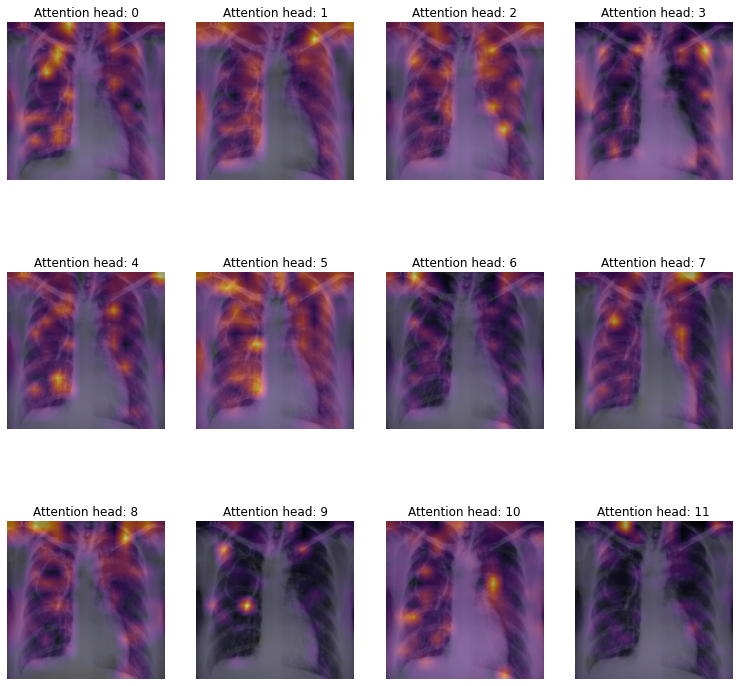

In [32]:
##Get the heatmap for test image
image = Image.open(PATH_TEST).convert("RGB")
image = image.resize((224, 224))

#Scale the image
image = np.array(image) 

img = image / 255.0
# Prepare the image for the model.
img = np.array(image)
#Move the color channel to the first dimension
img = np.moveaxis(img, -1, 0)
    
img = np.expand_dims(img, axis=0)


# Run the model and get the attention scores stored in a tuple
yhat, attention_score_tuple = transformer.predict(img)

in1k_mean = tf.constant([0.485 * 255, 0.456 * 255, 0.406 * 255])
in1k_std = tf.constant([0.229 * 255, 0.224 * 255, 0.225 * 255])
preprocessed_img_orig = np.expand_dims(np.array(image), axis=0)  #* in1k_std) + in1k_mean
preprocessed_img_orig = preprocessed_img_orig / 255.0
preprocessed_img_orig = tf.clip_by_value(preprocessed_img_orig, 0.0, 1.0).numpy()

# Generate the attention heatmaps.
attentions = attention_heatmap(attention_score_tuple, preprocessed_img_orig)

# Plot the maps.
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(13, 13))
img_count = 0

for i in range(3):
    for j in range(4):
        if img_count < len(attentions):
            axes[i, j].imshow(preprocessed_img_orig[0])
            axes[i, j].imshow(attentions[..., img_count], cmap="inferno", alpha=0.6)
            axes[i, j].title.set_text(f"Attention head: {img_count}")
            axes[i, j].axis("off")
            img_count += 1

In [41]:
train_generator.next()[1]

array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0.], dtype=float32)